## Problem Definition

Despite the availability of advanced weather forecasting engines, most are either black-box systems or require complex infrastructure and databases. This project simulates a **lightweight, production-ready weather forecasting pipeline** using only CSV-based storage — without relying on external databases or heavyweight infrastructure.

The system must:

- Collect **historical** and **live hourly** weather data via APIs
- Train a supervised **machine learning model** to predict the **next hour’s temperature**
- Expose the prediction pipeline as a **FastAPI REST service**
- Run in a **Dockerized** environment with proper testing, logging, and CI/CD automation
- Store and update data in **flat CSV files**, simulating minimal-infrastructure deployment

This problem captures the real-world challenges of:
- Time-series forecasting
- Resilient API integration
- Clean model deployment
- Lightweight ML system design under storage and tooling constraints


## Importing Necessary Libraries ##

In [70]:
import numpy as np
import pandas as pd
import requests
from scipy.stats import zscore
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import warnings

warnings.filterwarnings('ignore')

### Fetching and Saving Historical Data ###

In [2]:
# --- Parameters (Hyderabad) ---
latitude = 17.3850
longitude = 78.4867
start_date = "2023-05-01"
end_date = "2025-06-28"

# --- API Call ---
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": latitude,
    "longitude": longitude,
    "start_date": start_date,
    "end_date": end_date,
    "hourly": "temperature_2m,relative_humidity_2m,pressure_msl,wind_speed_10m",
    "timezone": "auto"
}

print(f"Fetching data for Hyderabad ({latitude}, {longitude}) from {start_date} to {end_date}...")
response = requests.get(url, params=params)

if response.status_code != 200:
    print("Failed to fetch data:", response.status_code, response.text)
    exit(1)

data = response.json()

# --- Convert to DataFrame ---
df = pd.DataFrame({
    "timestamp": data["hourly"]["time"],
    "temperature": data["hourly"]["temperature_2m"],
    "humidity": data["hourly"]["relative_humidity_2m"],
    "pressure": data["hourly"]["pressure_msl"],
    "wind_speed": data["hourly"]["wind_speed_10m"]
})

# --- Save to CSV ---
output_file = "historical_weather_hyd.csv"
df.to_csv(output_file, index=False)
print(f"Saved {len(df)} rows to {output_file}")


Fetching data for Hyderabad (17.385, 78.4867) from 2023-05-01 to 2025-06-28...
Saved 18960 rows to historical_weather_hyd.csv


In [2]:
df = pd.read_csv('historical_weather_hyd.csv')

In [3]:
df.shape

(18960, 5)

### Loading and Inspecting the Data ### 

In [4]:
#------The data is already sorted but when we add new data overtime, this helps in maintaining consistency.-----------
df = df.sort_values("timestamp").reset_index(drop=True) 

print(df.shape)          # rows, columns
print(df.head())
print(df.tail())
print(df["timestamp"].min(), "→", df["timestamp"].max())


(18960, 5)
          timestamp  temperature  humidity  pressure  wind_speed
0  2023-05-01T00:00         20.2        98    1009.6        14.8
1  2023-05-01T01:00         20.6        95    1008.1         4.8
2  2023-05-01T02:00         20.6        96    1007.6         5.8
3  2023-05-01T03:00         20.7        97    1007.4         3.3
4  2023-05-01T04:00         21.1        96    1008.0        10.5
              timestamp  temperature  humidity  pressure  wind_speed
18955  2025-06-28T19:00         29.0        57    1003.9         9.0
18956  2025-06-28T20:00         28.2        60    1004.6         9.0
18957  2025-06-28T21:00         27.6        61    1005.6        10.0
18958  2025-06-28T22:00         27.1        63    1006.3        11.1
18959  2025-06-28T23:00         26.5        64    1006.3        11.3
2023-05-01T00:00 → 2025-06-28T23:00


In [5]:
#---- Checking for the Missing Rows ----------------------
df.isnull().sum()

timestamp      0
temperature    0
humidity       0
pressure       0
wind_speed     0
dtype: int64

In [6]:
#---- Converting timestamp to datetime format --------------------
df['timestamp'] = pd.to_datetime(df['timestamp'])

#---- Setting timestamp as the index --------------------
#df.set_index('timestamp', inplace =True)

In [7]:
df.head()

,timestamp,temperature,humidity,pressure,wind_speed
0,2023-05-01 00:00:00,20.2,98,1009.6,14.8
1,2023-05-01 01:00:00,20.6,95,1008.1,4.8
2,2023-05-01 02:00:00,20.6,96,1007.6,5.8
3,2023-05-01 03:00:00,20.7,97,1007.4,3.3
4,2023-05-01 04:00:00,21.1,96,1008.0,10.5


In [8]:
#------- Extracting time based features ---------------

df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['weekday'] = df['timestamp'].dt.weekday  # 0 = Monday, 6 = Sunday


#-- These help the model learn patterns like “temperature usually drops after 7 PM” or 
#“pressure is higher in summer months”.----

In [9]:
df.head()

,timestamp,temperature,humidity,pressure,wind_speed,hour,day,month,weekday
0,2023-05-01 00:00:00,20.2,98,1009.6,14.8,0,1,5,0
1,2023-05-01 01:00:00,20.6,95,1008.1,4.8,1,1,5,0
2,2023-05-01 02:00:00,20.6,96,1007.6,5.8,2,1,5,0
3,2023-05-01 03:00:00,20.7,97,1007.4,3.3,3,1,5,0
4,2023-05-01 04:00:00,21.1,96,1008.0,10.5,4,1,5,0


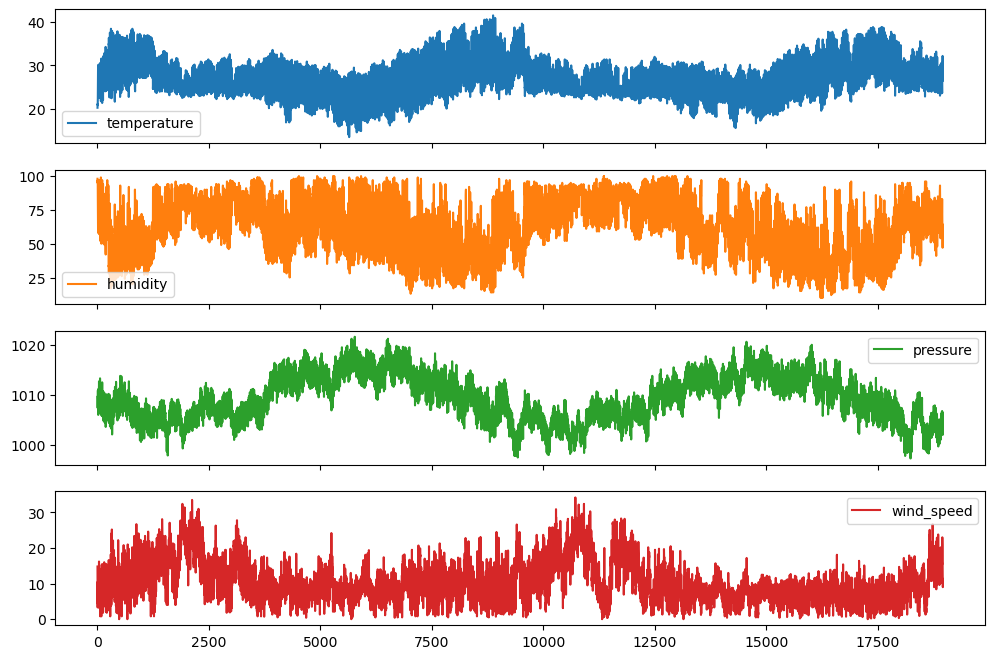

In [10]:
df[['temperature', 'humidity', 'pressure', 'wind_speed']].plot(subplots=True, figsize=(12, 8))
plt.show()

In [11]:
z_scores = df[['temperature', 'humidity', 'pressure', 'wind_speed']].apply(zscore)
outliers = (z_scores.abs() > 3).sum()
print("Outliers per column:\n", outliers)

Outliers per column:
 temperature     23
humidity         0
pressure         0
wind_speed     108
dtype: int64


In [12]:
df.loc[z_scores['temperature'].abs() > 3, 'temperature'].describe()

count    23.000000
mean     40.673913
std       0.397969
min      40.200000
25%      40.450000
50%      40.600000
75%      40.750000
max      41.600000
Name: temperature, dtype: float64

In [13]:
df.loc[z_scores['wind_speed'].abs()   > 3, 'wind_speed'].describe()

count    108.000000
mean      28.620370
std        1.555741
min       27.100000
25%       27.475000
50%       28.000000
75%       29.325000
max       34.200000
Name: wind_speed, dtype: float64

In [14]:
#------ Creating the target: Next Hour Temperature ----------------------------

df['temp_next_hour'] = df['temperature'].shift(periods=-1)

In [15]:
df = df.dropna(subset=['temp_next_hour']).copy()

In [16]:
print(df.shape)
df[['temperature', 'temp_next_hour']].head()

(18959, 10)


,temperature,temp_next_hour
0,20.2,20.6
1,20.6,20.6
2,20.6,20.7
3,20.7,21.1
4,21.1,20.8


In [17]:
#------Checking for the duplicates ----------------------

df.duplicated().sum()

0

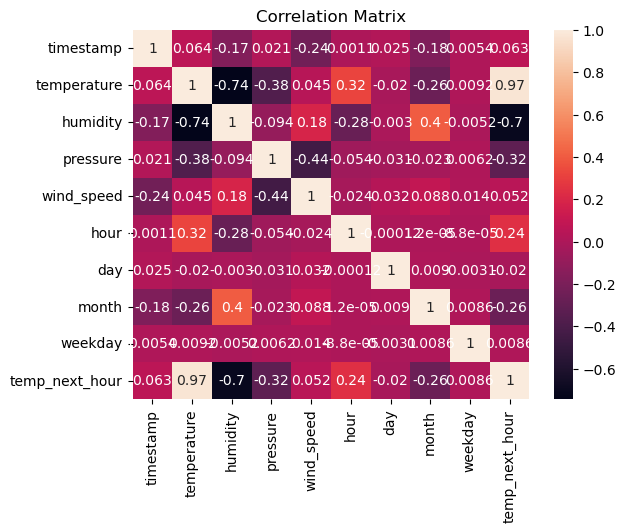

In [18]:
#---------Finding the correlation --------------------------
plt.title('Correlation Matrix')
sns.heatmap(df.corr(), annot=True)
plt.show()

In [19]:
df.corr()

,timestamp,temperature,humidity,pressure,wind_speed,hour,day,month,weekday,temp_next_hour
timestamp,1.000000,0.063509,-0.167778,0.021382,-0.236564,0.001113,0.025371,-0.183928,0.005401,0.063375
temperature,0.063509,1.000000,-0.744466,-0.375581,0.044571,0.319421,-0.020088,-0.264231,0.009206,0.967531
humidity,-0.167778,-0.744466,1.000000,-0.093768,0.183303,-0.278239,-0.003006,0.401577,-0.005192,-0.704211
pressure,0.021382,-0.375581,-0.093768,1.000000,-0.440607,-0.053744,-0.031476,-0.022968,0.006203,-0.321726
wind_speed,-0.236564,0.044571,0.183303,-0.440607,1.000000,-0.023870,0.032428,0.087827,0.014058,0.052294
hour,0.001113,0.319421,-0.278239,-0.053744,-0.023870,1.000000,-0.000123,0.000012,-0.000088,0.238038
day,0.025371,-0.020088,-0.003006,-0.031476,0.032428,-0.000123,1.000000,0.008955,-0.003093,-0.019844
month,-0.183928,-0.264231,0.401577,-0.022968,0.087827,0.000012,0.008955,1.000000,0.008623,-0.264631
weekday,0.005401,0.009206,-0.005192,0.006203,0.014058,-0.000088,-0.003093,0.008623,1.000000,0.008625
temp_next_hour,0.063375,0.967531,-0.704211,-0.321726,0.052294,0.238038,-0.019844,-0.264631,0.008625,1.000000


<h4>
    The day column has very low correlation with the target and adds little predictive value. Its raw numeric form misrepresents time (e.g., 31 → 1 jump), and any seasonal effects are already better captured by month and hour. Including it would likely introduce noise without improving model performance.
</h4>

In [26]:
#------ Preparing the feature matrix and target variable ---------------

X = df.drop(columns=['day', 'temp_next_hour', 'timestamp'])
y = df['temp_next_hour']

In [27]:
X.columns

Index(['temperature', 'humidity', 'pressure', 'wind_speed', 'hour', 'month',
       'weekday'],
      dtype='object')

In [28]:
#--- Here, I'm avoiding random split to avoid data leakage ------------
#---- the training data only sees the past, and the test data simulates future unseen data.-------

split_index = int(len(df)*0.8)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

## Modeling ##

### Establishing the Baseline Model ###

In [46]:
index = ['baseline_Model', 'rf_Model', 'gb_Model', 'weather_pipeline']
columns = ['Train_MAE', 'Test_MAE', 'Train_RMSE', 'Test_RMSE', 'Train_r2', 'Test_r2', 'CV']

analysis_df = pd.DataFrame(index=index, columns=columns)
analysis_df

,Train_MAE,Test_MAE,Train_RMSE,Test_RMSE,Train_r2,Test_r2,CV
baseline_Model,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rf_Model,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gb_Model,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weather_pipeline,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
#-- Creating a function that would predict and return all the required metrics ------

def make_prediction(model,model_key,  X_train, X_test, y_train, y_test, df_name):
    # Making Prediction on Training and Testing Data
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)

    df_name.loc[model_key, "Train_MAE"] = mean_absolute_error(y_train, y_train_predict)
    df_name.loc[model_key, "Test_MAE"] =  mean_absolute_error(y_test, y_test_predict)
    df_name.loc[model_key, "Train_RMSE"] = root_mean_squared_error(y_train, y_train_predict)
    df_name.loc[model_key, "Test_RMSE"] =  root_mean_squared_error(y_test, y_test_predict)
    df_name.loc[model_key, "Train_r2"] = r2_score(y_train, y_train_predict)
    df_name.loc[model_key, "Test_r2"] = r2_score(y_test, y_test_predict)
    df_name.loc[model_key, "CV"] = cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean()

    residuals = y_test - y_test_predict
    plt.figure(figsize=(6,3))
    plt.plot(residuals.reset_index(drop=True))
    plt.title("Test residuals")
    plt.show()

    return df_name

In [48]:
#--- Here, I'm starting with LinearRegression model

baseline_Model = LinearRegression()
baseline_Model.fit(X_train, y_train)

LinearRegression()

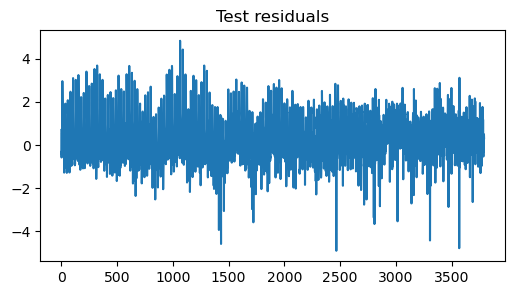

,Train_MAE,Test_MAE,Train_RMSE,Test_RMSE,Train_r2,Test_r2,CV
baseline_Model,0.741496,0.773921,1.004954,1.018112,0.946679,0.942823,0.932378
rf_Model,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gb_Model,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weather_pipeline,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
make_prediction(baseline_Model,"baseline_Model",  X_train, X_test, y_train, y_test, analysis_df)

## Random Forest Regressor ##

In [50]:
rf_Model = RandomForestRegressor()

In [51]:
rf_Model.fit(X_train, y_train)

RandomForestRegressor()

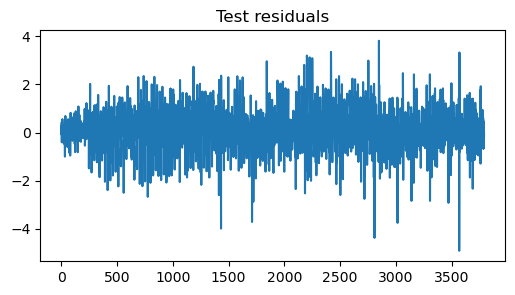

,Train_MAE,Test_MAE,Train_RMSE,Test_RMSE,Train_r2,Test_r2,CV
baseline_Model,0.741496,0.773921,1.004954,1.018112,0.946679,0.942823,0.932378
rf_Model,0.159226,0.524172,0.251558,0.741942,0.996659,0.969635,0.961724
gb_Model,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weather_pipeline,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
make_prediction(rf_Model,"rf_Model",  X_train, X_test, y_train, y_test, analysis_df)

## GradientBoostingRegressor ##

In [53]:
gb_Model = GradientBoostingRegressor()

In [54]:
gb_Model.fit(X_train, y_train)

GradientBoostingRegressor()

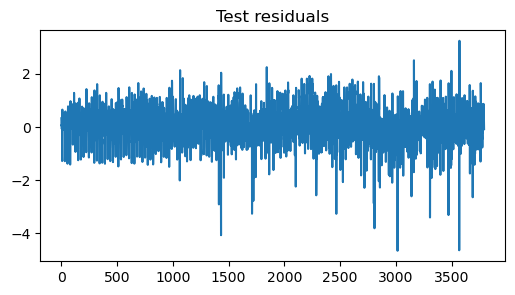

,Train_MAE,Test_MAE,Train_RMSE,Test_RMSE,Train_r2,Test_r2,CV
baseline_Model,0.741496,0.773921,1.004954,1.018112,0.946679,0.942823,0.932378
rf_Model,0.159226,0.524172,0.251558,0.741942,0.996659,0.969635,0.961724
gb_Model,0.427777,0.440418,0.657037,0.616758,0.977208,0.979017,0.965484
weather_pipeline,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
make_prediction(gb_Model,"gb_Model",  X_train, X_test, y_train, y_test, analysis_df)

<b> I'm choosing GradientBoostingRegressor as it has least overfitting and better explainability to the variation in data.

# Building The Model Pipeline #

### Writing the Sketch of pipeline.py ###

In [56]:
#--- BaseEstimator provides a skeleton to design scikit learn style models like fit, predict ---------
#--- TransformerMixin helps use logics like transform, fit_transform without writing the code -------
#---- Scikit learn conventions like fit, transform and fit_transform should be respected -------

class FeatureBuilder(BaseEstimator, TransformerMixin):
    """
    Stateless transformer that converts raw weather rows into model‑ready features.
    Expected input columns: timestamp, temperature, humidity, pressure, wind_speed
    """

    base_cols  = ["timestamp", "temperature", "humidity", "pressure", "wind_speed"]
    final_cols = ["temperature", "humidity", "pressure", "wind_speed",
                  "hour", "weekday", "month"]

    # No learned parameters ─ fit is a no‑op
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Accept either DataFrame or array‑like ‑> turn into DataFrame
        df = pd.DataFrame(X, columns=self.base_cols).copy()

        # Parse timestamp & engineer time features
        df["timestamp"] = pd.to_datetime(df["timestamp"])
        df["hour"]      = df["timestamp"].dt.hour
        df["weekday"]   = df["timestamp"].dt.weekday   # 0=Mon
        df["month"]     = df["timestamp"].dt.month

        return df[self.final_cols]

In [57]:
weather_pipeline = Pipeline([
    ("feat", FeatureBuilder()),
    ("model", GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])

In [58]:
# Raw column list for training / inference
raw_cols = ["timestamp", "temperature", "humidity", "pressure", "wind_speed"]

In [62]:
weather_pipeline.fit(df[raw_cols].iloc[:split_index], y_train)

Pipeline(steps=[('feat', FeatureBuilder()),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.05, n_estimators=300,
                                           random_state=42))])

In [63]:
raw_cols = ["timestamp", "temperature", "humidity", "pressure", "wind_speed"]
target_col = "temp_next_hour"

In [65]:
split_idx = int(len(df) * 0.8)

In [66]:
X_train_raw = df[raw_cols].iloc[:split_idx]
y_train = df[target_col].iloc[:split_idx]

X_test_raw = df[raw_cols].iloc[split_idx:]
y_test = df[target_col].iloc[split_idx:]

In [69]:
# Make predictions
y_train_predict = weather_pipeline.predict(X_train_raw)
y_test_predict = weather_pipeline.predict(X_test_raw)

# Calculate metrics
train_mae = mean_absolute_error(y_train, y_train_predict)
test_mae = mean_absolute_error(y_test, y_test_predict)

train_rmse = root_mean_squared_error(y_train, y_train_predict)
test_rmse = root_mean_squared_error(y_test, y_test_predict)

train_r2 = r2_score(y_train, y_train_predict)
test_r2 = r2_score(y_test, y_test_predict)

# Cross-validation on the raw train set
cv_score = cross_val_score(weather_pipeline, X_train_raw, y_train, cv=5, scoring='r2').mean()

# Print
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train R²:", train_r2)
print("Test R²:", test_r2)
print("Cross-validated R²:", cv_score)


Train MAE: 0.41500567035764224
Test MAE: 0.4432720306466152
Train RMSE: 0.6393871249804481
Test RMSE: 0.6276200626762739
Train R²: 0.9784157612386686
Test R²: 0.9782717843779412
Cross-validated R²: 0.9656251213345797


In [74]:
import joblib
joblib.dump(weather_pipeline, "weather_pipeline.pkl")

['weather_pipeline.pkl']

# Model Testing #

In [75]:
pipeline = joblib.load("weather_pipeline.pkl")

In [77]:
latitude = 17.3850
longitude = 78.4867

url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": latitude,
    "longitude": longitude,
    "hourly": "temperature_2m,relative_humidity_2m,pressure_msl,wind_speed_10m",
    "timezone": "auto",
    "forecast_days": 1
}

response = requests.get(url, params=params)
forecast_data = response.json()

In [78]:
df_forecast = pd.DataFrame({
    "timestamp": forecast_data["hourly"]["time"],
    "temperature": forecast_data["hourly"]["temperature_2m"],
    "humidity": forecast_data["hourly"]["relative_humidity_2m"],
    "pressure": forecast_data["hourly"]["pressure_msl"],
    "wind_speed": forecast_data["hourly"]["wind_speed_10m"]
})

# Here I'm again Converting timestamp to datetime
df_forecast["timestamp"] = pd.to_datetime(df_forecast["timestamp"])


In [80]:
# Using the next available hour
current_row = df_forecast
print(current_row)

             timestamp  temperature  humidity  pressure  wind_speed
0  2025-07-01 00:00:00         24.1        91    1005.3        12.1
1  2025-07-01 01:00:00         23.9        91    1004.7        13.5
2  2025-07-01 02:00:00         23.8        89    1004.4        13.9
3  2025-07-01 03:00:00         23.8        88    1004.1        12.4
4  2025-07-01 04:00:00         23.7        88    1003.9        12.0
5  2025-07-01 05:00:00         23.6        89    1004.2        11.5
6  2025-07-01 06:00:00         23.7        89    1005.1        11.6
7  2025-07-01 07:00:00         24.0        87    1005.7        13.6
8  2025-07-01 08:00:00         24.5        85    1006.2        14.6
9  2025-07-01 09:00:00         25.4        81    1005.9        17.3
10 2025-07-01 10:00:00         25.8        78    1005.5        17.3
11 2025-07-01 11:00:00         25.8        81    1005.5        14.8
12 2025-07-01 12:00:00         25.9        80    1005.4        15.9
13 2025-07-01 13:00:00         25.4        87   

In [81]:
# Since here i'm to predict only about next hour, i have to do slicing
current_row = df_forecast.iloc[0:1]  
print(current_row)

   timestamp  temperature  humidity  pressure  wind_speed
0 2025-07-01         24.1        91    1005.3        12.1


In [82]:
prediction = pipeline.predict(current_row)[0]
print(f"Predicted temperature for next hour: {prediction:.2f}°C")

Predicted temperature for next hour: 23.94°C


In [1]:
import os

os.getcwd()

'C:\\Users\\DELL\\Data Science\\Machine Learning\\Supervised Learning\\Capstone Projects\\weather-predictor\\notebooks'

In [2]:
import numpy as np
import pandas as pd
import requests
import scipy
import seaborn as sns
import matplotlib
import sklearn

print("Library Versions:")
print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")
print(f"requests: {requests.__version__}")
print(f"scipy: {scipy.__version__}")
print(f"seaborn: {sns.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"scikit-learn: {sklearn.__version__}")


Library Versions:
numpy: 1.26.4
pandas: 2.2.2
requests: 2.32.3
scipy: 1.13.1
seaborn: 0.13.2
matplotlib: 3.9.2
scikit-learn: 1.5.1


In [16]:
import pandas as pd
from pathlib import Path


ROOT_DIR = Path().resolve().parents[1]
DATA_DIR = ROOT_DIR/"data"

data = DATA_DIR/"DATA_FRAME.csv"
assert Path(data).exists(), "Engineered data file does not exist"

WindowsPath('C:/Users/DELL/Data Science/Machine Learning/Supervised Learning/Capstone Projects/data/DATA_FRAME.csv')

In [18]:
from pathlib import Path

data_dir = Path("C:/Users/DELL/Data Science/Machine Learning/Supervised Learning/Capstone Projects/data")

print("Contents of data/:")
for file in data_dir.iterdir():
    print("-", file.name, "| Is file:", file.is_file())


Contents of data/:


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\DELL\\Data Science\\Machine Learning\\Supervised Learning\\Capstone Projects\\data'